In [1]:
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from jupyterthemes import jtplot
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
    

jtplot.style()
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("covid19") \
    .getOrCreate()

print(sys.version, "\n", tf.__version__)

3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0] 
 2.2.0


In [2]:
def format_for_poly(prices):
    cols = [c for c in prices.columns if c.endswith("Close")]
    prices = prices[cols].drop("Average_Close", axis=1)
    rename_scheme = dict(zip(prices.columns.tolist(), [c [:-6] for c in prices.columns]))
    prices = prices.rename(columns=rename_scheme)
    
    return prices

def intersection(prices, fund):
    fund_cols = fund.columns
    stocks_cols = [c for c in prices.columns]
    inter_cols = [c for c in fund_cols if c in stocks_cols]

    fund = fund[inter_cols]
    prices = prices[inter_cols]

    prices = prices.transpose()
    fund = fund.transpose()
    
    return prices, fund

In [3]:
prices = spark.read.csv("testing_set.csv", header=True, inferSchema=True).drop("_c0").toPandas()
fund_raw = pd.read_csv("fund.csv").drop("Unnamed: 0", axis=1)

prices, time = prices.iloc[:, 1:], prices.iloc[:, :1]

prices = format_for_poly(prices)
prices, fund = intersection(prices, fund_raw)

assert(prices.shape[0] == fund.shape[0])

## Polynomial Approximation with fundamentals
Let $M^{(i)}$ be the polynomial that models time series i:
$$M^{(i)}(t) = \theta_0^{(i)} + \theta_1^{(i)} t + \theta_2^{(i)} t^2 + \dots + \theta_{n+1}^{(i)} t^n$$

We would like to generate the $\theta$ for time series i directly from the information contained in its fundamentals. Hence, we create an implicit linear model $F \times B$ that takes as input our fundamentals and some coefficient $\beta$ and then deterministically outputs $\theta$.
We then optimize $\beta$ with the loss from the polynomial model.

<br /><br />
$$ F \times B = \Theta $$
$$
\begin{bmatrix}
F_{11} & F_{12} &  \dots & F_{1n} \\
F_{21} & F_{22} &  \dots & F_{2n} \\
F_{n1} & F_{n2} &  \dots & F_{nn} \\
\end{bmatrix} \times
\begin{bmatrix}
\beta_{11} & \beta_{12} &  \dots & \beta_{1n} \\
\beta_{21} & \beta_{22} &  \dots & \beta_{2n} \\
\beta_{n1} & \beta_{n2} &  \dots & \beta_{nn} \\
\end{bmatrix} =
\begin{bmatrix}
\theta_{0}^{(1)} & \theta_{1}^{(1)} &  \dots & \theta_{n}^{(1)} \\
\theta_{0}^{(2)} & \theta_{1}^{(2)} &  \dots & \theta_{n}^{(2)} \\
\theta_{0}^{(n)} & \theta_{1}^{(n)} &  \dots & \theta_{n}^{(n)} \\
\end{bmatrix}
$$
$$ \text{(405 stocks, 300 fund) x (300, 10) = (405 series, 10+1 degrees)}$$
<br />

* With $F_{ij}$, the fundamental j of the $i^{th}$ series
* The column $\beta_{*j}$ contains the coefficients the we optimize.
* $\theta_k^{(i)}$ is the $k^{th}$ coefficient of the polynomial for series $(i)$

We can then use the rows $\Theta^{(i)}$ to build a polynomial approximation for time series (the stock price) number i.

### Example

(100, 1)

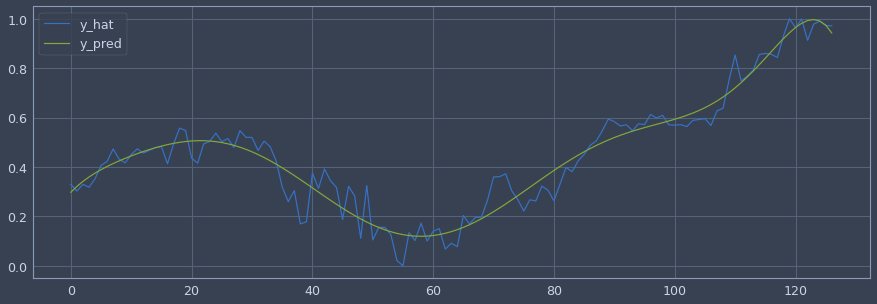

In [294]:
series = x_train["AAPL_Close"]
model = np.poly1d(np.polyfit(series.index.tolist(), series, 10))
df = pd.DataFrame({"y_hat": series, "y_pred": model(series.index.tolist())})
ax = df.plot(y="y_hat", figsize=(15, 5))
df.plot(y="y_pred", ax=ax)
x_test.shape

### Implementation

In [4]:
import scipy as sp
mse = keras.losses.MeanSquaredError()

def loss(M, data):
    t = np.arange(data.shape[1])
    loss = 0
    for i, poly in enumerate(M):
        y_pred = poly(t)
        loss += mse(y_pred, data.iloc[i]).numpy()
    print(loss, end=" ")
    return loss

def poly_models(F, B):
    B = B.reshape(features, -1)
    theta = np.matmul(F, B)
    for i, row in enumerate(theta):
        M[i] = np.poly1d(row)
    
    return M

def fit(F, prices):
    loss_f = lambda B: loss(poly_models(F, B), prices)
    ret = sp.optimize.minimize(loss_f, x0=np.zeros((features, degree + 1)))
    
    return ret

In [ ]:
stocks = 304
features = 300
degree = 1

# Fundamentals: (405 x 300)
F = fund.to_numpy()
assert(fund.shape == (stocks, features))
# Beta independent coefficients (300 x 11)
B = np.zeros((features, degree + 1))
# Theta dependent poylonomial coefficients (405 x 11)
theta = np.zeros((stocks, degree + 1))
# Polynomial matrix (405 x 1)
M = [0 for _ in range(stocks)]

model = fit(F, prices)

79.62378133833408 79.62378133833408 111936889038.08142 21048223.512366414 106131534783.63742 19955206.879698977 120216582246.9802 22605681.4268267 106009392284.46733 19931895.61319547 76957070.44396476 14806.559215955436 124146286.5224171 24062.00535356626 139933038.9128 26890.425900813192 716722805.6458993 134930.30790724605 295441659.496747 55326.213454792276 56222035.337525785 10514.58609110117 255723832.51142976 47720.02335147932 101657582.91050369 18931.42429695651 79.61416718363762 79.62363465875387 79.61752731353045 79.62368171662092 3973727.716631584 786.1137245595455 13112559.147705786 2470.016204304993 4406845136.065517 834357.1066258326 5216383195.502017 986972.0010793507 4958885722.536608 938623.4079549611 4435902758.165667 839680.357131578 53500167042.14581 10052047.644515187 54132983071.89206 10170653.66633365 54737716470.79514 10284277.196282852 56677988433.65797 10648122.251387253 186164.70996763557 111.29188942909241 246852.1954016015 122.20595387369394 49011.535273157

79.61963830143213 79.62371327728033 79.61917252093554 79.62370423227549 79.61122205853462 79.6235897988081 79.61541623622179 79.62364795804024 79.6053350046277 79.62349358201027 79.60823966562748 79.62353153526783 79.62089232355356 79.6237335652113 79.62082133442163 79.6237321048975 79.62064429372549 79.62372970581055 79.62010079622269 79.62372021377087 79.592186242342 79.62328366190195 79.59364522248507 79.62330231070518 79.59471548348665 79.62331940233707 79.5950824841857 79.62332436442375 537780963.8950671 100043.93203049153 601007005.4376158 111875.54944229126 667122135.5215696 124259.47468964756 744699774.6372846 138788.5193456076 288506202493.01154 54263995.6187069 327201902288.0198 61544059.62620157 368588069068.34534 69331181.19160694 392647583698.02466 73857703.22043276 1748777927.8487334 331739.5074108131 3794301597.3213205 717868.5745430738 2765022917.724014 524165.6418111995 2204707832.7571297 418547.62749319524 46840234863.845184 8799426.630112771 45843780749.00019 8611623

1.414387926050141e+30 1.4143879260592742e+30 1.4143879260497086e+30 1.4143879260592742e+30 1.4143879260502848e+30 1.4143879260592742e+30 1.414387925450531e+30 1.4143879260592742e+30 1.4143879254459197e+30 1.4143879260592742e+30 1.41438792544592e+30 1.4143879260592742e+30 1.4143879254456317e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592737e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592703e+30 1.4143879260592742e+30 1.414387926059264e+30 1.4143879260592742e+30 1.4143879260592728e+30 1.4143879260592742e+30 1.4143879260595247e+30 1.4143879260592742e+30 1.4143879260592556e+30 1.4143879260592742e+30 1.4143879260592554e+30 1.4143879260592742e+30 1.4143879260592734e+30 1.4143879260592742e+30 1.4143879260592706e+30 1.4143879260592742e+30 1.4143879260592714e+30 1.41438792605927

1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 1.4143879260592742e+30 584757436482.2882 584757436482.2882 256227674997.07648 579555572440.8628 270464750747.4722 579792136820.5371 251367502707.6105 579401306967.6233 270994939288.739 579799831243.3722 582984525657.383 584735514829.2211 588474425850.6582 584800068414.9957 589509568873.1063 584812160798.952 565048758769.587 584515370520.8273 580744847652.4727 584706409944.4127 583659585441.0977 584743760627.0471 582878447498.9828 584732169273.7354 583545664706.0787 584741881137.9227 584757436442.9471 584757436480.1904 584757436439.1439 584757436480.2214 584761246615.1133 584757435248.5408 584770160065.8633 584757434260.242 606068250206.341 584958712154.7946 607801516941.625 584969813544.6439 607487624210.0117 584969098598.3073 605856297183.3865 584955859151.0925 389229800323.76794 581814592402.9786 389030939743.274 581804847856.2592 388685590574.9127 581793688827.7056 3898

584757436432.3195 584757436480.1749 584757436438.5226 584757436480.2218 584757436363.796 584757436479.9406 584757436352.5538 584757436480.1749 584757436469.4288 584757436482.2218 584757436473.1124 584757436482.2218 584757436469.589 584757436482.253 584757436458.9054 584757436482.2257 584757436294.2765 584757436478.7335 584757436295.1671 584757436478.7413 584757436291.5265 584757436478.8741 584757436294.0734 584757436478.7648 583041461356.64 584730812087.882 582933805741.6228 584728797597.4327 582779259327.8665 584726193444.2843 582637968191.676 584723612715.0656 492753628351.1185 580299741592.257 488677546432.877 579799825963.632 492538235483.5881 579362649579.2238 465748848044.67065 578764227736.3312 593231188322.8574 584837529294.1163 607311472708.8982 584980606676.6476 591538728569.925 584805602363.4171 596947762732.2283 584876281541.1163 401692813370.3757 582040098485.4562 400920507372.77954 582042565114.003 400800953578.4999 582003006763.8976 422483551136.42664 582320779455.4679 1

109683413825.64319 21950468395.27366 121796333236.95676 22231497380.268448 157033329702.6108 22394322314.093605 136840328534.18721 22259034693.70347 77014327493.2525 21766265699.52195 18368634496.26249 21522561548.874367 16044133797.320456 21503543193.26499 18054760437.42633 21512276550.91575 14494410973.022545 21475248163.70249 39609255921.964195 21791803393.455788 19568126784.16329 21626225063.135475 23171675696.190422 21651668800.778664 27769902057.628624 21691698676.632668 18850190051.361786 21529890453.878517 16493387982.696247 21510643650.31431 18524892007.768852 21519767498.318092 15021572591.76992 21484644766.81333 20010751478.227726 21513185328.840187 17050577637.579319 21493024513.92466 19146171918.974045 21504618461.670876 14715112475.94415 21471181685.602394 22584205604.49894 21276720483.147804 24429000886.383938 21278565217.60679 16394073531.235825 21269702194.53794 19434219741.901016 21325734919.838844 19362193363.2697 21627207400.133278 19915090797.5409 21636580376.02219

1069218719.6836966 932439066.670845 1204062880.6016064 933810634.7316437 1035362078.793045 931917438.8166046 1105472128.2672687 929069527.2437172 1129581664.9090052 928780042.8678474 1085916638.603289 929503589.1858978 1099802752.0918336 930206767.561882 166400333568.6155 908152985.2044754 190831292201.84152 910336141.9173374 207248804256.2601 911626497.8622282 221697577399.2989 912589126.7987995 19596792032.621563 858312158.0427952 19644551862.131603 858354930.5081062 18475814720.268566 859285156.4073563 27907574727.017513 859516165.85993 938274889.0342331 930997595.1353683 945114048.2248154 930998788.323204 931020395.2627945 930996432.3986322 932174167.913063 930996611.5254955 94468727374.96875 849751252.3816757 94013928655.59766 846385029.6365166 97290624655.78313 846535822.8056865 87602316939.18948 848493274.2114325 2482028265.048021 921300222.1934166 1592930184.0897818 916139561.7548485 1451666607.567151 916752936.4705563 840645803.3298321 917223237.7518673 7569344858.240231 91766

930996438.9237428 679117051.9902143 918124300.7584634 578469393.0065699 919537105.8388352 572706084.2536645 919150188.3042588 758423905.9037828 924668943.948214 41256071.345139325 41256071.345139325 108279143115.2651 18442522.050633073 102642102812.40274 19345331.595327854 116448490258.69864 18691511.418552876 102525440950.6254 19386979.01527983 102678019.07004592 41086587.43536854 195574601.02279356 41637827.755993366 219921865.53257823 41742164.96974683 586448037.6596591 39356958.05319899 300519206.4862934 40882324.258374214 87786245.98832807 41151584.2529974 279052735.86180437 41091137.74900651 131883556.9830114 41144132.39473009 41256070.80683774 41256071.33693284 41256070.85002339 41256071.337491035 45228345.9330945 41256761.54796648 54365284.405322075 41258423.004900455 4590059189.525276 43773648.04821924 5407354552.421295 44018247.335767746 5149383589.445709 43964282.26398468 4617092792.550646 43754970.7637763 51450109999.54515 26509836.839962006 52075940865.011154 26545624.4953

In [ ]:
import pickle

file= open("poly_model", "w")
pickle.dump(model, file)